<a href="https://colab.research.google.com/github/Akramkhan01/Face-Emotion-Recognition-Deep-Learning-Project/blob/main/Face_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Project Name**

**Live Class Monitoring System(Face Emotion Recognition)**


# **Project Introduction**

The Indian education landscape has been undergoing rapid changes for the past 10 years owing to the advancement of web-based learning services, specifically, eLearning platforms.

Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market is growing on a rapid scale, there are major challenges associated with digital learning when compared with brick and mortar classrooms. One of many challenges is how to ensure quality learning for students. Digital platforms might overpower physical classrooms in terms of content quality but when it comes to understanding whether students are able to grasp the content in a live class scenario is yet an open-end challenge.

In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who need special attention. Digital classrooms are conducted via video telephony software program (exZoom) where it’s not possible for medium scale class (25-50) to see all students and access the mood. Because of this drawback, students are not focusing on content due to lack of surveillance. While digital platforms have limitations in terms of physical surveillance but it comes with the power of data and machines which can work for you. It provides data in the form of video, audio, and texts which can be analysed using deep learning algorithms. Deep learning backed system not only solves the surveillance issue, but it also removes the human bias from the system, and all information is no longer in the teacher’s brain rather translated in numbers that can be analysed and tracked.

# **Problem Statements**

We will solve the above-mentioned challenge by applying deep learning algorithms to live video data.

The solution to this problem is by recognizing facial emotions.

# **What is Face Emotion Recognition**

Facial emotion recognition is the process of detecting human emotions from facial expressions. The human brain recognizes emotions automatically, and software has now been developed that can recognize emotions as well.

# **Dataset Information:**
I have built a deep learning model which detects the real time emotions of students through a webcam so that teachers can understand if students are able to grasp the topic according to students' expressions or emotions and then deploy the model. The model is trained on the FER-2013 dataset .This dataset consists of 35887 grayscale, 48x48 sized face images with seven emotions - angry, disgusted, fearful, happy, neutral, sad and surprised.




In [ ]:
import os
import cv2
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## CNN Models ##
import keras
import tensorflow as tf
from tensorflow.keras import optimizers
from keras.utils import np_utils
from keras.regularizers import l2
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D,concatenate
from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import load_model

from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
batch_size = 32
num_epochs = 50
input_shape = (48, 48, 1)
validation_split = .2
verbose = 1
num_classes = 7
base_path = 'models/'
shape_x = 48
shape_y = 48
image_size=(48,48)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cd /content/gdrive/MyDrive/Face Emotion Recognition - Akram Khan

In [ ]:
# Converting our data from tar file to csv file
import tarfile

fname = 'fer2013.tar.gz'
if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()
elif fname.endswith("tar"):
    tar = tarfile.open(fname, "r:")
    tar.extractall()
    tar.close()

In [ ]:
# Reading CSV file
df = pd.read_csv('/content/gdrive/MyDrive/Face Emotion Recognition - Akram Khan/fer2013/fer2013.csv')

In [ ]:
# Printing shape of the data
print(df.shape)

In [ ]:
# Return the first 5 rows.
df.head()

In [ ]:
# Return unique values emotion
df.emotion.unique()

In [ ]:
# Dictionary mapping for individual emotions
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [ ]:
# Plotting distribution of emotions
sns.countplot(df.emotion)
plt.show()

From above plot we can observe that majority of the classes belongs to **3:Happy, 4:Sad** and **6:Neutral** on the otherside **1:disgust** and **5:surprise** are less in classes.

In [ ]:
# Value counts on each set
df["Usage"].value_counts()

In [ ]:
# Let's plot the count of each set
sns.countplot(df.Usage)
plt.show()

#**Displaying Images**

In [ ]:
# Visulize sample dataset
fig = plt.figure(1, (14, 14))
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(3):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

#**Preprocessing**

In [ ]:
df['pixels']=df['pixels'].astype("string") #converting dtype of pixels to string
pixels = df['pixels'].tolist() #Making list of pixels
width, height = 48, 48 # initializing image shape
faces = [] #Empty list
# Making images as required for our models  
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.strip().split(' ',48*48)]
    face = np.asarray(face).reshape(width, height)
    face = cv2.resize(face.astype('uint8'),image_size)
    faces.append(face.astype('float32'))
# Converting to array and dimension for transfer Learning
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)
faces /= 127.5 # normalizing the data
faces -= 1.
# Converting Emotions to numpy array
emotions = pd.get_dummies(df['emotion']).to_numpy()

#**Data Augmentation**
**Data Augmentation**:- taking the batch and apply some series of random transformations (random rotation, resizing, shearing) to increase generalizability of model.

In [ ]:
# data generator Generate batches of tensor image data with real-time data augmentation
data_generator = ImageDataGenerator(
                        featurewise_center=False,#Set input mean to 0 over the dataset, feature-wise.
                        featurewise_std_normalization=False,# Divide inputs by std of the dataset, feature-wise.
                        rotation_range=10,      # randomly rotate images in the range (degrees, 0 to 180)
                        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                        height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
                        zoom_range=.1,          # randomly zoom into images
                        horizontal_flip=True)   # randomly flip images

ImageDataGenerator

horizontal and vertical shift => moving all pixels of image in one direction

1. width_shift_range ( horizonatal shift)

2. height_shift_range (vertical shift)

3. floating num [0- 1] --> % of shift

* horizontal n vertical flips augmentation ==>reversing rows or cols of pixels --> True or False

* Random rotation --> 0 - 360 degrees --> rotation_range = 90 ==> means random rotation to image blw 0 and 90 degrees

* random brightness --> randomly darkens or brightens images ==> brightness_range =[0.2,1.0] --> means darkens or brightens if pixel is blw 0.2 and 1

* random zoom

1. either adds pixel or subtract pixels in image . [1-value, 1+value]

2. for example , zoom_range = .3 --> range [0.7, 1.3] or blw 70%(zoom in) and 130% (zoomout)

#**Splitting data into train and test datset**

In [ ]:
#train test split
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.3,shuffle=True)
xval,xtest,yval,ytest=train_test_split(xtest,ytest,test_size=0.3,shuffle=True)

In [ ]:
# Checking shapes
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape, xval.shape, xtest.shape, yval.shape, ytest.shape

#**Method 1: Xception :**

[Paper](https://arxiv.org/pdf/1610.02357.pdf)



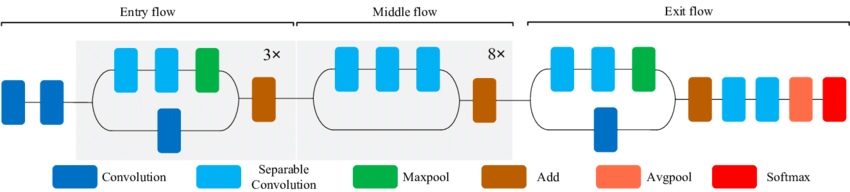

#**Modelling**

In [ ]:
# Defining entry flow
def entry_flow(inputs) :
    
    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    previous_block_activation = x
    
    for size in [64, 128, 256] :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = MaxPooling2D(3, strides=2, padding='same')(x)
        
        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
        
        x = keras.layers.Add()([x, residual])
        previous_block_activation = x
    
    return x

In [ ]:
# Defining middle flow
def middle_flow(x, num_blocks=8) :
    
    previous_block_activation = x
    
    for _ in range(num_blocks) :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x
    
    return x

In [ ]:
# Defining exit flow
def exit_flow(x, num_classes=7) :
    
    previous_block_activation = x
    
    x = Activation('relu')(x)
    x = SeparableConv2D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = keras.layers.Add()([x, residual])
      
    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    return x

In [ ]:
# creating input and output of model
inputs = Input(shape=(shape_x, shape_y, 1))
outputs = exit_flow(middle_flow(entry_flow(inputs)))

In [ ]:
# saving the model
xception = Model(inputs, outputs,name="Xception")

In [ ]:
# Plotting architecture of defined model
plot_model(xception, to_file='xception.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Compiling the model
xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
xception.summary()  #gives the information about the architecture and configuration of the neural network.

#**Method 4: CNN inspired by Goodfellow I.J**

[Paper](https://arxiv.org/pdf/1307.0414.pdf)

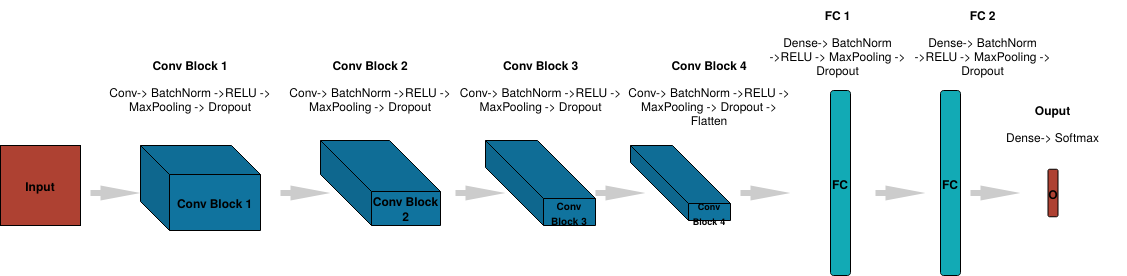

In [ ]:
# Building up Model Architecture
def CNN():
    model = Sequential()

    #1st CNN layer
    model.add(Conv2D(64,(3,3),padding = 'same', name='image_array', input_shape = (48,48,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.25))

    #2nd CNN layer
    model.add(Conv2D(128,(5,5),padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout (0.25))

    #3rd CNN layer
    model.add(Conv2D(512,(3,3),padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout (0.25))

    #4th CNN layer
    model.add(Conv2D(512,(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    #Fully connected 1st layer
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))


    # Fully connected layer 2nd layer
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(num_classes, activation='softmax'))

    return model

In [ ]:
CNN=CNN()

In [ ]:
# Plotting architecture of defined model
plot_model(CNN, to_file='CNN.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Compiling the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001) #using Adam Optimizer
CNN.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
CNN.summary() #gives the information about the architecture and configuration of the neural network.

#**Training**

#**Xception**

In [ ]:
# Fitting the Model with Training and Validation Data
early_stop = EarlyStopping('val_loss', patience=50, min_delta=0, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=int(50/4), min_delta=0.0001,model='auto')
trained_models_path = base_path + '_Xception'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, early_stop, reduce_lr]

In [ ]:
# Fitting the xception model
xception_history =xception.fit(data_generator.flow(xtrain, ytrain, batch_size),
          steps_per_epoch=len(xtrain) / batch_size, 
          epochs=num_epochs, 
          verbose=1, 
          callbacks=callbacks,
          validation_data=(xtest,ytest))

It took around 45 to 50 minutes to run all 70 epochs. The training gave the accuracy of 72% approx and val_accuracy of 64%.

It gives good prediction on train as well as test data.

Let's see the performance of Trained Deep CNN model

#**Trained Deep Convolutional Neural Network(CNN):**

In [ ]:
# Fitting the Model with Training and Validation Data
early_stop = EarlyStopping('val_loss', patience=50)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=25, min_lr=0.00001,model='auto')
trained_models_path = base_path + 'CNN'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True, mode='max')
callbacks = [model_checkpoint, early_stop, reduce_lr]

In [ ]:
# Fitting the CNN model
CNN_history =CNN.fit(data_generator.flow(xtrain, ytrain, batch_size),
          steps_per_epoch=len(xtrain) / batch_size,
          epochs=num_epochs, 
          verbose=1, 
          callbacks=callbacks,
          validation_data=(xtest,ytest))

#**Plotting Accuracy & Loss**

In [ ]:
# Plotting accuracy and loss curve for each model
fig,axes=plt.subplots(2,2,figsize=(20, 20))
for (m,history), ax in zip({'CNN':CNN_history,'Xception':xception_history}.items(),axes):
    # Loss Curves    
    ax[0].plot(history.history['loss'],'r',linewidth=2.0)
    ax[0].plot(history.history['val_loss'],'b',linewidth=2.0)
    ax[0].legend(['Training loss', 'Validation Loss'],fontsize=18)
    ax[0].set_xlabel('Epochs ',fontsize=16)
    ax[0].set_ylabel('Loss',fontsize=16)
    ax[0].set_title('Loss Curves '+m,fontsize=16)
 
    # Accuracy Curves
    ax[1].plot(history.history['accuracy'],'r',linewidth=2.0)
    ax[1].plot(history.history['val_accuracy'],'b',linewidth=2.0)
    ax[1].legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    ax[1].set_xlabel('Epochs ',fontsize=16)
    ax[1].set_ylabel('Accuracy',fontsize=16)
    ax[1].set_title('Accuracy Curves '+m,fontsize=16)

In [ ]:
# saving the plot
plt.savefig('plots.png')

From above loss and accuracy plot it is seen that the accuracy & loss curve of Trained Deep CNN model is gradually increasing also the validation loss curve is below the training loss curve on the other hand the Xception shows the slightly lower accuracy compare to the trained CNN model.

#**Classificastion Reports**

In [ ]:
# Printing the classification report of all models
for model in [CNN,xception]:
    ypred=model.predict(xtest)
    ypred_=np.argmax(ypred, axis=1)
    ytest_=np.argmax(ytest, axis=1)
    print(classification_report(ytest_, ypred_,digits=3))

From above classification report it is seen that the **Recall**, **Precision** and **f1** score of **Custom trained Deep CNN modedl** is high compare to Xception model.

#**Confusion Matrix**

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure

# Printing the confusion matrix for each model
for model,i in zip([CNN,xception],[1,2,3]):
    fig = figure(figsize=(10, 10))
    
    ypred=model.predict(xtest)
    rounded_predections=np.argmax(ypred, axis=1)
    rounded_labels=np.argmax(ytest, axis=1)
    cm = confusion_matrix(rounded_labels, rounded_predections)
    labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    title='Confusion matrix '+model.name
    

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_'+model.name+'.png')
    plt.show()

From the confusion metrix above we observe the emotions that are correctly predicted w.r.t actual emotions.

In above confusion metrices the **Deep CNN model** has predicted most of the emotions correctly comapare to **Xception model.**

Now we are going to use the **Trained CNN Model** for live video face emotion recognition.

#**Real Time Video Face Detection Using Local Webcam**

In [ ]:
# Save best Model
CNN.save('Final_model.h5')

In [ ]:
# Saving model in json format along with weights
fer_json = xception.to_json()  
with open("fer.json", "w") as json_file:  
    json_file.write(fer_json)  
xception.save_weights("fer.h5")

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image,clear_output
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# Defining function to detect face
def face_detect():
  import cv2
  from PIL import Image
  import numpy as np
  import os
  from keras.models import load_model
  from time import sleep
  from keras.preprocessing.image import img_to_array
  from keras.preprocessing import image
# start streaming video from webcam
  video_stream()
# label for video
  label_html = 'Capturing...'
# initialze bounding box to empty
  bbox = ''
  count = 0
  face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + '/content/gdrive/MyDrive/Face Emotion Recognition - Akram Khan/haarcascade_frontalface_default.xml') # Face Detection
  classifier =load_model('/content/gdrive/MyDrive/Face Emotion Recognition - Akram Khan/Final_model.h5')  #Load model
  emotion_labels = ['Angry','Disgust','Fear','Happy','Neutral', 'Sad', 'Surprise'] 

  while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
      break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(0,255,0),2)
      roi_gray = gray[y:y+h,x:x+w]
      roi_gray = cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)  ##Face Cropping for prediction
      if np.sum([roi_gray])!=0:
        roi = roi_gray.astype('float')/255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi,axis=0) ## reshaping the cropped face image for prediction
        prediction = classifier.predict(roi)[0]   #Prediction
        label=emotion_labels[prediction.argmax()]
        label_position = (x,y)
        cv2.putText(bbox_array,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)   # Text Adding
      else:
        cv2.putText(bbox_array,'No Faces',(30,80),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)

    



    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

In [ ]:
# Finally detecting the face with live webcam
face_detect()